### Imports

In [1]:
# External packages
import os
import pandas as pd
from statannotations.Annotator import Annotator
from scipy.stats import normaltest

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *

# Figures dictionary
figs = {}

### Load dataset-aggregated data of response state dependency across lines

In [2]:
lines = ['line3', 'sst']
root = split_path_at(get_data_root(), 'raw')[0]
corrcoeffs = []
for line in lines:
    fpath = os.path.join(root, f'corrcoeffs_{line}.csv')
    s = pd.read_csv(fpath).assign(line=line).set_index('line')
    for k in [Label.DATASET, Label.ISPTA]:
        s.set_index(k, append=True, inplace=True)
    corrcoeffs.append(s.sort_index())
corrcoeffs = pd.concat(corrcoeffs, axis=0)
corrcoeffs

R
line  dataset                 I_SPTA (W/cm2)          
line3 20190704_mouse2_region1 0.00           -0.592156
                              0.04           -0.579223
                              0.15           -0.655362
                              0.20           -0.526026
                              0.62           -0.640729
...                                                ...
sst   20190808_mouse8_region1 7.91           -0.365721
                              9.89           -0.423918
                              11.87          -0.339938
                              13.85          -0.358370
                              15.83          -0.298370

[495 rows x 1 columns]

### Plot and compare correlation coefficients trends across lines

 2023/10/11 15:32:57: plotting results vs ISPTA...


 2023/10/11 15:32:57: testing normality of distributions...
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

line3 vs. sst: Mann-Whitney-Wilcoxon test two-sided, P_val:2.967e-10 U_stat=1.974e+04


Text(0.5, 1.05, 'state dependent response strength - comparative analysis')

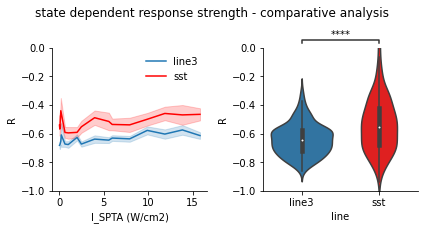

In [4]:
# Create figure and axes
figs['corrcoeff comparison'], axes = plt.subplots(1, 2, figsize=(6, 3))
for ax in axes:
    sns.despine(ax=ax)
    ax.set_ylim(-1, 0)

# Plot correlation coefficient distributions vs ISPTA
logger.info('plotting results vs ISPTA...')
sns.lineplot(
    ax=axes[0],
    data=corrcoeffs,
    x=Label.ISPTA,
    y='R',
    hue=Label.LINE,
    palette=Palette.LINE,
    errorbar='se',
)
axes[0].legend(frameon=False)

# Determine whether distributions are normal
logger.info('testing normality of distributions...')
normalres = (corrcoeffs
    .groupby(Label.LINE)
    .agg(lambda s: normaltest(s).pvalue)
    ['R']
    .rename('pval')
    .to_frame()
)
normalres['normal'] = normalres['pval'] > 0.05
normalres

# Derive statistical test to use
if normalres['normal'].all():
    test = 't-test_ind'
else:
    test = 'Mann-Whitney'

# Plot comparative correlation coefficient distributions aggregated across conditions 
pltkwargs = dict(
    ax=axes[1],
    data=corrcoeffs.reset_index(),
    x=Label.LINE,
    y='R',
    palette=Palette.LINE,
)
sns.violinplot(**pltkwargs)

# Perform statistical test and annotate plot 
annotator = Annotator(pairs=[tuple(lines)], **pltkwargs)
annotator.configure(test=test, loc='outside')
annotator.apply_and_annotate()

# Adjust layout
figs['corrcoeff comparison'].tight_layout()
figs['corrcoeff comparison'].suptitle('state dependent response strength - comparative analysis', y=1.05)